# Relembrando

<a href="https://colab.research.google.com/github/glaucogoncalves/nio/blob/main/lectures/05_02_NSGA_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Voltemos ao problema multiobjetivo. Formalmente, temos

$
\displaystyle\min_{\boldsymbol{x} \in \mathbb{R}^D} \boldsymbol{f}(\mathbf{x}) = [f_1(\mathbf{x}),f_2(\mathbf{x}),\ldots,f_M(\mathbf{x})] \\
s.t. \\
g_j(\mathbf{x}) \leq 0, \; j = 1,2,\ldots,J \\
h_k(\mathbf{x}) = 0, \; k = 1,2,\ldots,K
$

onde $\mathbf{x} = (x_1,x_2,\ldots,x_D)^T$ é o vetor de variáveis de decisão.

A solução de problemas multiobjetivo depende do conceito de **dominância**. Diz-se que um vetor solução $\mathbf{x} = (x_1,\ldots,x_D)^T$ domina o vetor $\mathbf{x'} = (x'_1,\ldots,x'_D)^T$, se e somente se, $\mathbf{f(x)} \prec \mathbf{f(x')}$. Assim, para quaisquer dois vetores solução $\mathbb{x}$ e $\mathbb{x'}$ existem <u>três possibilidades</u>:

* $\mathbb{x}$ domina $\mathbb{x'}$; ou
* $\mathbb{x'}$ domina $\mathbb{x}$; ou
* $\mathbb{x}$ e $\mathbb{x'}$ não dominam um ao outro.

Uma solução viável $\mathbf{x^*}$ é chamada um <u>ótimo de Pareto</u> para um problema de otimização multiobjetivo se não existir um outro vetor solução viável que domine $\mathbf{x^*}$. Em outras palavras, **soluções ótimas são aquelas que não são dominadas por outras soluções**.

Diferentemente da otimização monoobjetivo, onde uma única solução ótima nos interessa, em problemas multiobjetivo a otimização nos leva um conjunto de soluções, chamada de **conjunto de ótimos de Pareto**, formado inteiramente por soluções não-dominadas. A imagem deste conjunto **no espaço de objetivo é chamada de fronteira de Pareto**.

Vimos que há três formas de reconstrução da fronteira de Pareto:
1. Método da função de utilidade monoobjetivo;
2. Método da $\epsilon$-restrição ($\epsilon$-*constraint*); e
3. Aproximação do conjunto Pareto-ótimo, por meio de metaheuristicas.

Vimos que os métodos 1 e 2 podem ser criticados por **gerar soluções que não cobrem bem a fronteira de Pareto** e **porque a fronteira obtida depende da formulação**. Portanto as metahuerísticas citadas no item 3 tem o papel de **encontrar um conjunto de soluções bem distribuídas sobre a fronteira de Pareto**, esta é uma preocupação fundamental como veremos à frente.

Há um grande número de metahuerísticas para problemas multiobjetivo e, em essência, **uma metaheurística percorre o espaço de solução avaliando as soluções em termos de sua dominância**. Aqui abordaremos o *Non-dominated Sorting Genetic Algorithm* (NSGA-II). Esta metaheurística é usada para problemas com dois objetivos e segue a ideia geral de um algoritmo genético. Por isso, começaremos apresentando o funcionamento dos <u>algoritmos genéticos</u>.

Para o estudo seremos apoiado pela biblioteca ```pymoo```.

## Preparação

In [ ]:
!pip install -q pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


A documentação da biblioteca ```pymoo``` está acessível em
https://pymoo.org/index.html

# NSGA-II

O NSGA-II (DEB et al., 2002) é um AG voltado à problemas de otimização multiobjetivo e é considerado um dos mais poderosos algoritmos evolucionários multiobjetivo. Para lidar com este tipo de problema, pode-se dizer de forma resumida que o NSGA-II modifica a forma como os cruzamentos são feitos e os melhores candidatos são escolhidos.

O NSGA-II é baseado no *Nondominated Sorting Genetic Algorithm* (NSGA) desenvolvido por (SRINIVAS; DEB, 1994). A ideia básica do NSGA é, partindo de uma população de soluções, explorar o espaço de busca escolhendo as soluções pela sua dominância, movendo-se em direção da fronteira de Pareto. As principais críticas a este algoritmo são: a **alta complexidade computacional da busca por soluções não-dominantes** e a **necessidade do ajuste de um hiperparâmetro para determinar quando duas soluções são consideradas próximas**.

Para lidar com estes problemas, o NSGA-II adiciona três mecanismos novos:

* Um procedimento eficiente (i.e., polinomial) de ordenação não-dominada (*non-dominated sorting*)
* Um procedimento eficiente de estimação do isolamento (*crowded distance*) de uma solução
* Um operador de comparação que estende a dominância clássica usando o conceito de isolamento



## Ordenação não-dominada

A base do NSGA de 1994 e do NSGA-II é o conceito de ordenação não-dominada, o qual fora originalmente proposto por Goldberg e Holland (1988). A ordernação não-dominada parte do pressuposto de que as soluções podem ser organizadas em diferentes fronteiras, de tal forma que as soluções dentro de uma fronteira são não-dominantes entre si.

A figura abaixo ilustra esta ideia. Nela, vemos as soluções (em verde) destacadas como nível 1 (*level 1*). Estas são as soluções da fronteira de Pareto e, portanto, são as soluções não-dominadas. Contudo, se relaxarmos o conceito de dominância, pode-se dizer que as soluções do nível 2 (em azul), embora sejam dominadas pelo nível 1, formam uma nova fronteira de soluções que também não se dominam entre si, mas que dominam as soluções do nível 3 (em rosa), por exemplo. Pode-se dizer que as soluções do nível 1 tem uma dominância "mais forte" do que o nível 2, que, por sua vez, é mais forte que o nível 3. Observe que esta versão de dominância mais relaxada pode ser aplicada indefinidamente, criando-se sucessivos níveis com dominância ainda mais fraca.

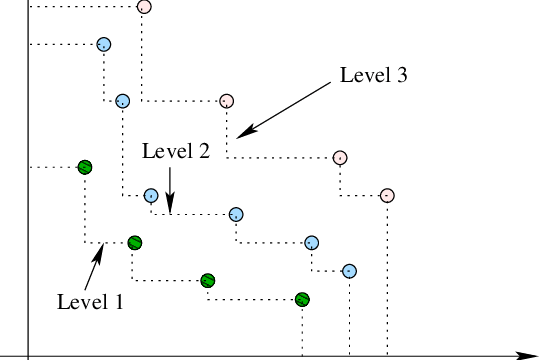

A principal ideia da ordenação não-dominada é organizar as soluções nas múltiplas fronteiras de dominância, de modo a poder explorar tanto o elitismo (escolha dos melhores) quanto a diversidade (escolha de soluções não tão boas, para melhorar a exploração do espaço de busca).

Essencialmente, o procedimento de ordenação não-dominada no NSGA de 1994 consiste em comparar as soluções entre si para determinar as soluções no primeiro nível de não-dominância. Em seguida, estas são temporariamente removidas, e uma nova comparação é feita. Nesta segunda rodada de comparação, as soluções não-dominadas formam a segunda fronteira. Estas, por sua vez, são removidas e uma terceira rodada de comparação se segue para determinar o nível 3. O procedimento segue até que todas as soluções estejam em alguma fronteira.

Como se pode observar este é um procedimento custoso, cuja complexidade é $O(MN^3)$, onde $M$ é o número de funções objetivo e $N$ é o tamanho da população. O algoritmo NSGA-II modifica esta estratégia e reduz a complexidade para $O(MN^2)$, armazenando informações de dominância obtidas na primeira iteração do algoritmo para determinar a primeira fronteira. Detalhes de implementação deste método eficiente de ordenação não-dominada podem ser encontrados em (DEB et al., 2002).

## Estimativa de isolamento

Para <u>manter a diversidade na população é importante que o AG use uma medida de distância entre as soluções</u> do problema multiobjetivo. O algoritmo NSGA de 1994 emprega uma estratégia que computa a distância entre duas soluções, mas que depende de um hiperparâmetro que determina até que ponto duas soluções podem ser ditas próximas.

Um outro aspecto importante é que a o algoritmo de solução do problema multiobjetivo <u>deve obter uma boa cobertura da fronteira de Pareto</u>.

Para obter uma boa cobertura e, ao mesmo tempo, simplificar o processo de comparação de distâncias, o algoritmo NSGA-II procura atender estes critérios propondo a medida de <u>**isolamento**, que estima a densidade de pontos em torno de uma solução, na fronteira a qual a solução pertence</u>.

Para determinar o isolamento de uma solução $i$, usa-se as posições das soluções $i-1$ e $i+1$ em sua própria fronteira. A partir das posições calcula-se a distância de Manhattan entre estas duas soluções, como mostrado abaixo.

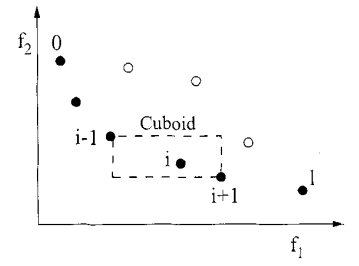

Esta medida consegue atender os critérios porque:

1.   Não possui nenhum hiperparâmetro a ser configurado;
2.   Não precisa comparar os indivíduos entre si; e
3.   quanto mais distante uma solução estiver de seu antecessor e sucessor na fronteira, maior será a medida de isolamento, e portanto, mais relevante será aquela solução para manter uma cobertura uniforme de sua fronteira.


## Operador de dominância ciente da aglomeração

Além de olhar para a dominância clássica entre as soluções, o NSGA-II incorpora a medida de isolamento no operador de comparação entre soluções.

Assumindo que cada indivíduo $i$ na população tem dois atributos: $i_{\text{rank}}$ e $i_{\text{isolation}}$ os quais indicam, respectivamente, a fronteira de dominância onde o indivíduo se encontra e a aglomeração do indíviduo. Assim, **o operador de dominância ciente da aglomeração** ($\prec_n$) (*crowded-comparison operator*) é definido como:

$i \prec_n j \iff (i_{\text{rank}} \lt j_{\text{rank}}) \; \text{or} \; (i_{\text{rank}} = j_{\text{rank}} \; \text{and} \; i_{\text{isolation}} \gt j_{\text{isolation}} ) $

Assim, entre duas soluções em diferentes fronteiras, nós preferimos aquela que está na fronteira de menor nível. Caso ambas as soluções pertençam a mesma fronteira, nós preferimos aquelas que estejam em uma região da fronteira menos aglomerada.

## Algoritmo

O primeiro passo do NSGA-II é gerar uma população aleatória $P_0$ de tamanho $N$ de soluções candidatas. Desta população, aplicando-se os operadores de cruzamento, mutação e seleção, gera-se a prole $Q_0$. Para esta primeira prole pode-se usar quaisquer operadores de cruzamento e mutação e é comum o uso do operador de torneio binário na seleção com base na função de aptidão como critério na seleção.

Após esta inicialização, o NSGA-II segue o procedimento abaixo:

> Enquanto $t <n_{gen}$ faça: \\
>> $R_t = P_t \cup Q_t$ \\
>> $F = \text{ordenação-não-dominada}(R_t)$ \\
>> $P_{t+1} = \varnothing$ \\
>> $i = 1$ \\
>> $\text{Enquanto} \; |P_{t+1}| + |F_i| \leq N \; \text{faça:}$ \\
>> $\;\;\; \text{calcula-isolamento}(F_i)$ \\
>> $\;\;\; P_{t+1} = P_{t+1} \cup F_i$ \\
>> $\;\;\; i = i+1$ \\
>> $\text{ordena}(F_i,\prec_n)$ \\
>> $P_{t+1} = P_{t+1} \cup F_i[1:(N-|P_{t+1}|)]$ \\
>> $Q_{t+1} = \text{criar-nova-prole}(P_{t+1})$ \\
>> $t = t+1$

O procedimento determina que deve-se combinar pais e filhos formando todos os cromossomos candidatos ($R_t$). Em seguida estes são ordenados com base na dominância de forma a determinar a fronteira em que cada uma das soluções se encontra ($F_1,F_2,\ldots$).

Em seguida, a nova população $P_{t+1}$ será formada com base nas melhores soluções. Iniciando pela primeira, cada fronteira $F_i$ será adicionada inteiramente, se possível, até atingir-se o limite de $N$ soluções candidatas. Além disto, o isolamento de cada solução em $F_i$ é calculado. Caso uma fronteira $F_i$ não possa ser adicionada inteiramente ao conjunto $P_{t+1}$, o laço é interrompido e as soluções de $F_i$ são ordenadas em ordem decrescente com base no operador de dominância ciente da aglomeração. As melhores, segundo este critério, são adicionadas em $P_{t+1}$.

A última etapa consiste na geração de nova prole $Q_{t+1}$. Neste caso usa-se os operadores de mutação e cruzamento empregados anteriormente e o operador de seleção de torneio binário. Contudo, o critério de seleção usado baseia-se no operador de dominância ciente da aglomeração. Desta forma, garante-se a escolha de soluções melhores segundo o nível de sua fronteira (elitismo) e segundo seu espalhamento na fronteira (melhorando a diversidade).





A imagem abaixo ilustra este processo.

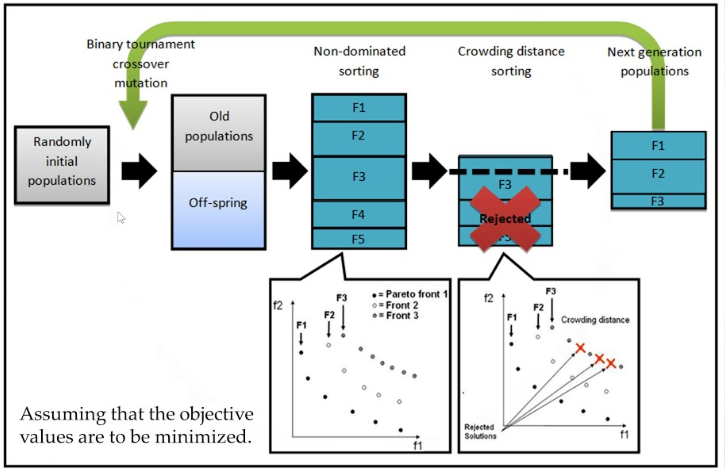

## Usando o NSGA-II na prática

Vamos retormar ao exemplo que usamos anteriormente em que temos o problema abaixo:

$\min_{x,y} f_1(x,y) = \frac{x^2}{4} + \frac{y^2}{2} + 2x -3y \\
 \min_{x,y} f_2(x,y) = \frac{x^2}{2} + y^2 - 2x +6y$

O gráfico de contorno abaixo mostra as duas funções ($f_1$ em azul e $f_2$ em verde) e mostra ainda em vermelho uma linha tracejada ligando os pontos de ótimo das funções e indicando o conjunto de soluções pareto ótimas.

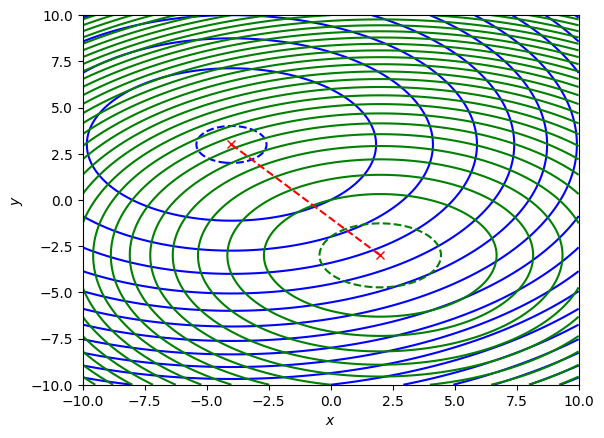

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 1000
x = np.linspace(-10, 10, n)
y = np.linspace(-10, 10, n)
xv, yv = np.meshgrid(x, y)
f1 = xv**2/4 + yv**2/2 + 2*xv -3*yv
f2 = xv**2/2 + yv**2 - 2*xv + 6*yv

plt.contour(x,y,f1,levels=20,colors="blue")
plt.contour(x,y,f2,levels=30,colors="green")

#y = -x - 1
plt.plot(-4,3,'x',color="red")
plt.plot(2,-3,'x',color="red")
plt.plot([-4,2],[3,-3],'--',color="red")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Abaixo nós resolvemos o problema com a biblioteca ```pymoo```.

Começamos estabelecendo o problema multiobjetivo na classe ```Exemplo``` que herda da classe ```Problem```. No construtor indicamos que o problem tem duas  variáveis de decisão (```n_var = 2```), dois objetivos (```n_obj = 2```) e que não possui restrições (```n_constr = 0```). Além disso, especificamos os limites inferior ```xl``` e superior ```xu``` de cada variável, sendo que os valores da lista são usados na ordem portanto, neste caso, temos que $-100 \leq x,y \leq 100$.

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import  SBX
import matplotlib.pyplot as plt


class Exemplo(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=[-100,-100], xu=[100,100])

    def _evaluate(self, x, out, *args, **kwargs):
        xv = x[:,0]
        yv = x[:,1]
        f1 = np.power(xv,2)/4 + np.power(yv,2)/2 + 2*xv - 3*yv
        f2 = np.power(xv,2)/2 + np.power(yv,2) - 2*xv + 6*yv
        out["F"] = np.column_stack((f1,f2))

problem = Exemplo()

algorithm = NSGA2(pop_size=50,
                  mutation=PolynomialMutation(prob=0.5, eta=20),
                  crossover=SBX(prob=1.0, prob_var=0.5, eta=20))

res = minimize(problem,
               algorithm,
               ('n_gen', 3),
               save_history=True,
               seed=1)

### Fronteira de Pareto

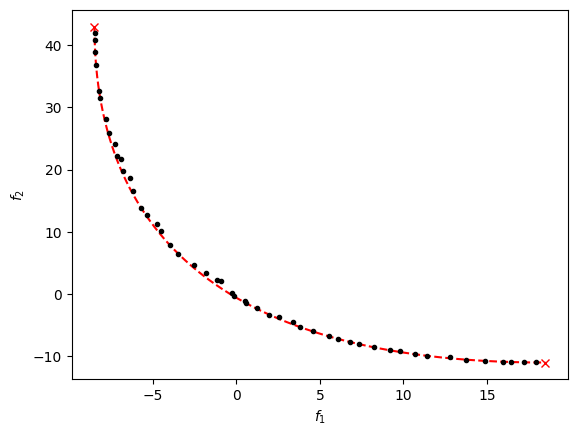

In [ ]:
n = 1000
x = np.linspace(-4, 2, n)
y = -x-1

def f1(x,y):
  return x**2/4 + y**2/2 + 2*x -3*y

def f2(x,y):
  return x**2/2 + y**2 - 2*x + 6*y

plt.plot(f1(x,y),f2(x,y),"--",color="red")
plt.plot(f1(-4,3),f2(-4,3),'x',color="red")
plt.plot(f1(2,-3),f2(2,-3),'x',color="red")

f1 =res.F[:,0]
f2 = res.F[:,1]
plt.plot(f1,f2,'.',color="black")

plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.show()

### Soluções pareto ótimas

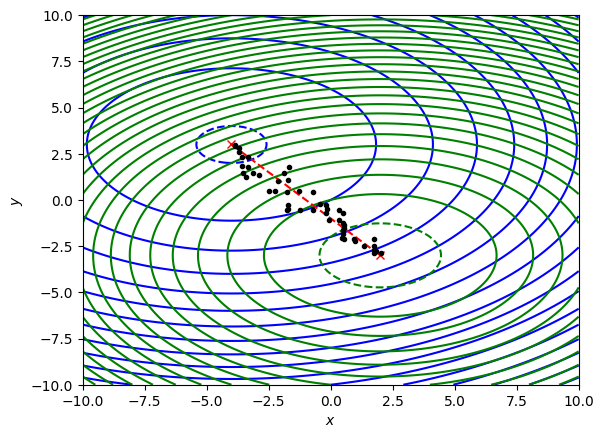

In [ ]:
n = 1000
x = np.linspace(-10, 10, n)
y = np.linspace(-10, 10, n)
xv, yv = np.meshgrid(x, y)
f1 = xv**2/4 + yv**2/2 + 2*xv -3*yv
f2 = xv**2/2 + yv**2 - 2*xv + 6*yv

plt.contour(x,y,f1,levels=20,colors="blue")
plt.contour(x,y,f2,levels=30,colors="green")

#y = -x - 1
plt.plot(-4,3,'x',color="red")
plt.plot(2,-3,'x',color="red")
plt.plot([-4,2],[3,-3],'--',color="red")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(res.X[:,0],res.X[:,1],'.',color="black")
plt.show()

### Evolução das soluções

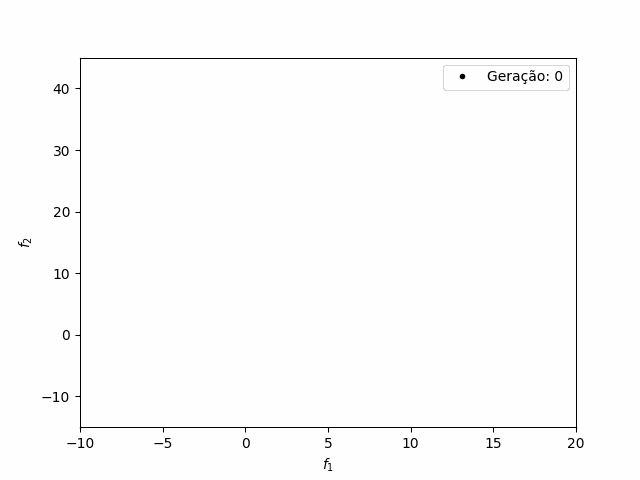

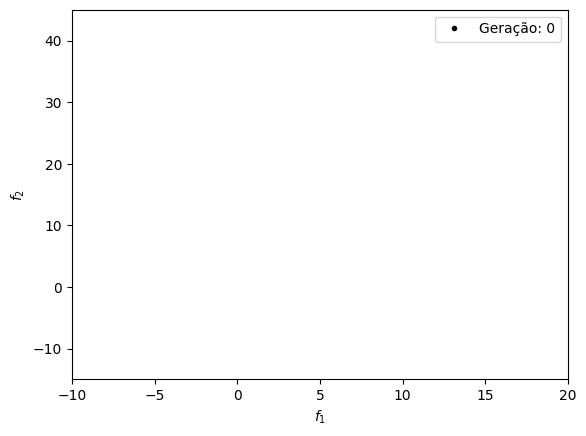

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image

fig, ax = plt.subplots()
a = res.history[0]
b = a.result()

scat = ax.plot(b.F[:,0],b.F[:,1],'.',color="black",label="Geração: 0")[0]
ax.set(xlim=[-10, 20], ylim=[-15, 45], xlabel='$f_1$', ylabel='$f_2$')
L = ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    a = res.history[frame]
    b = a.result()
    x = b.F[:,0]
    y = b.F[:,1]
    # update the scatter plot:
    scat.set_xdata(x)
    scat.set_ydata(y)
    L.get_texts()[0].set_text("Geração: "+str(frame))
    return scat #(scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=50, interval=60)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=2, bitrate=1800)
ani.save('scatter.gif', writer=writer)
Image(open('scatter.gif','rb').read())

## Críticas

Criado há cerca de 20 anos, o NSGA-II pode ser dito como a metahueristica padrão para solução de problemas de otimização multiobjetivo (NEBRO et al., 2022). Novas técnicas são em geral comparadas com o NSGA-II e esta é, geralmente, a primeira escolha para solução de problemas deste tipo no mundo real.

Deve-se destacar que o NSGA-II tem uma conhecida limitação em convergir ao lidar com problemas com muitos objetivos (KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B., 2006), os quais são chamados de ***many-objective problems*** em contraposição aos *multi-objective problems*. Tais problema com muitos objetivos podem ter 3, 4 ou mais objetivos, podendo chegar à dezenas de objetivos.

Embora a mecânica de funcionamento do NSGA-II não o impeça de trabalhar com mais objetivos, sabe-se que ele tem dificuldades em manter uma população diversa já nas primeiras interações do algoritmo. A principal causa disso, como mostram (KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B., 2006), é que <u>a probabilidade de termos soluções não-dominadas já no sorteio inicial das soluções aumenta com o número de funções objetivos</u>.



Mostramos este resultado experimentalmente abaixo.

Com base no problema padronizado DTLZ2 com 15 variáveis e um número variável de funções objetivos (de 2 a 30 funções), fazemos apenas a primeira iteração do NSGA-II, com uma população de 100 cromossomos, e medimos o número de soluções não-dominadas. Repetimos este experimento 100 vezes.

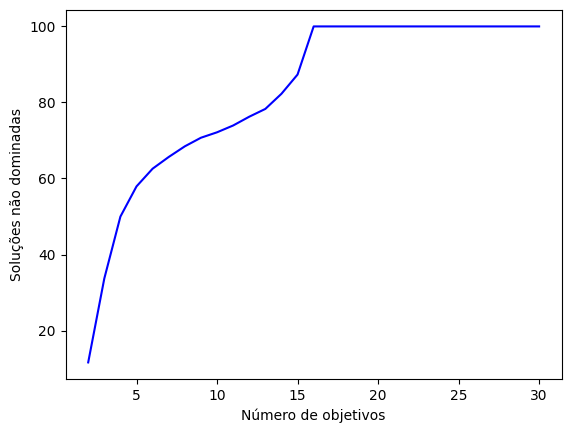

In [ ]:
import numpy as np
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import  SBX
import matplotlib.pyplot as plt

rank1 = []
obj_exp = range(2,31)

for objs in obj_exp:
  media = []
  for i in range(100):
    problem = get_problem("DTLZ2", n_var=15, n_obj = objs)
    algorithm = NSGA2(pop_size=100)
    res = minimize(problem,
                  algorithm,
                  ('n_gen', 1),
                  seed=i)
    media.append(len(res.F))
  rank1.append(np.mean(media))

plt.plot(obj_exp,rank1,color="blue")

plt.xlabel("Número de objetivos")
plt.ylabel("Soluções não dominadas")
plt.show()

O experimento para 2 a 5 objetivos, a quantidade de soluções não-dominadas cresce rapidamente. Além disso, para uma quantidade grande de objetivos, praticamente todas as soluções geradas inicialmente são não-dominadas. Isso faz com que o operador de dominância ciente de aglomeração trabalhe apenas com o isolamento, o qual, em uma população inicial, é bastante aleatório fazendo com que o algoritmo não caminhe para convergência, tornando-se quase como uma busca aleatória.

Diversas propostas (várias implementadas na biblioteca ```pymoo```) tentam modificar o NSGA-II para obter uma seleção inicial melhor. Esta é inclusive uma das motivações da proposição do NSGA-III, proposto pelos autores originais do NSGA-II (DEB & JAIN, 2013).

# Referências

DEB, K.; AGRAWAL, R. B. [**Simulated binary crossover for continuous search space**](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d3c8dca5e1629dbd7bef6c6ef0187820802437d5). Complex systems, 9(2):115-48, 1995.

DEB, K.; JAIN, H., **An evolutionary many-objective optimization algorithm using reference-point-based nondominated sorting approach, part I: solving problems with box constraints**. IEEE transactions on evolutionary computation, 18(4), pp.577-601, 2013.

DEB, K.; PRATAP, A.; AGARWAL, S.; MEYARIVAN, T. [**A fast and elitist multiobjective genetic algorithm: Nsga-ii**](https://cs.uwlax.edu/~dmathias/cs419/readings/NSGAIIElitistMultiobjectiveGA.pdf). IEEE transactions on evolutionary computation, IEEE, v. 6, n. 2, p. 182–197, 2002.

DEB, K.; SINDHYA, K.; OKABE, T. [**Self-adaptive simulated binary crossover for real-parameter optimization**](https://core.ac.uk/download/pdf/291575195.pdf), 9th Annual Conference on Genetic and Evolutionary Computation, 1187–1194. New York, NY, USA, 2007.

DOBNIKAR, A.; STEELE, N.C.; PEARSON, D.W.; ALBRECHT, R.F.; DEB, K.; AGRAWAL, S., 1999. [**A niched-penalty approach for constraint handling in genetic algorithms**](https://web.archive.org/web/20051205012724id_/http://vision.ucsd.edu:80/~sagarwal/icannga.pdf). Proceedings of the International Conference in Portorož, Slovenia,  Springer Vienna, pp. 235-243, 1999.

GOLDBERG, D. E.; HOLLAND, J. H. **Genetic algorithms and machine learning**. Machine learning, Springer, v. 3, n. 2, p. 95–99, 1988.

KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B. **Fuzzy-pareto-dominance and its application in evolutionary multi-objective optimization**.International conference on evolutionary multi-criterion optimization, pp. 399-412, 2005.

NEBRO, A.J.; GALEANO-BRAJONES, J.; LUNA, F.; COELLO COELLO, C.A. **Is NSGA-II Ready for Large-Scale Multi-Objective Optimization?**. Mathematical and Computational Applications, 27(6), p.103,  2022.

SRINIVAS, N.; DEB, K. **Multiobjective optimization using nondominated sorting in genetic algorithms**. Evolutionary computation, MIT Press, v. 2, n. 3, p. 221–248, 1994.